In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
#import astromet
import dev.astromet.astromet as astromet
import numpy as np
import matplotlib.pyplot as plt

# an object wich holds all the necessary parameters to generate the astrometric track
params=astromet.params()

# center of mass parameters
params.ra=160     #[deg]
params.dec=-50    #[deg]
params.drac=0     #[mas]
params.ddec=0     #[mas]
params.pmrac=4    #[mas/yr]
params.pmdec=3   #[mas/yr]
params.parallax=2     #[mas]

In [3]:
# random times - a very rough approximation to Gaia eDR3
ts=2016 + ((34/12)*np.sort(np.random.rand(100))-(17/12))

# optionally use the much simpler Kepler equation solver if numba causes errors
#astromet.use_backup=True

# finds the exact position in RAcos(Dec) and Dec [mas]
racs,decs=astromet.track(ts,params)

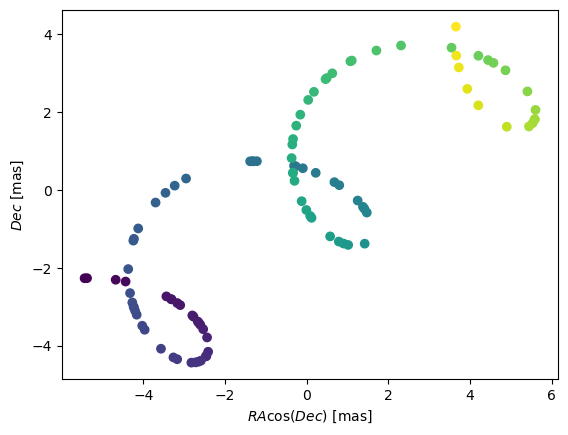

In [4]:
ax=plt.gca()
ax.scatter(racs,decs,c=ts)
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/singleBody.png')
plt.show()

In [5]:
# binary parameters
# (for single stars leave these blank or set l=q)
params.period=2      #[yr]
params.a=2    #[AU]
params.e=0.5
params.q=0.5
params.l=0.1
# viewing angle
params.vphi=4.5   #[rad]
params.vtheta=1.5 #[rad]
params.vomega=5.6 #[rad]
# time of some periapse passage
params.tperi=2016 #[jyear]

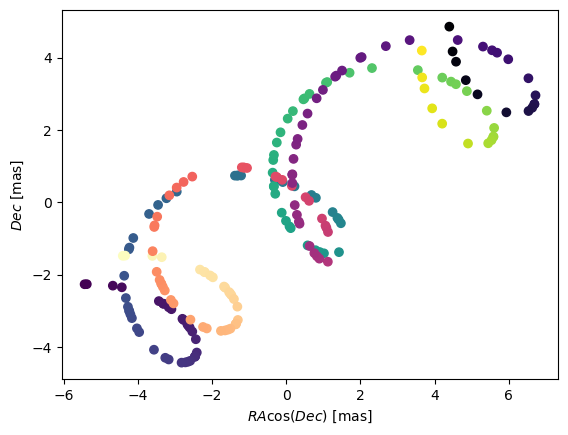

In [6]:
bracs,bdecs=astromet.track(ts,params)

ax=plt.gca()
ax.scatter(racs,decs,c=ts)
ax.scatter(bracs,bdecs,c=ts,cmap='magma_r')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBody.png')
plt.show()

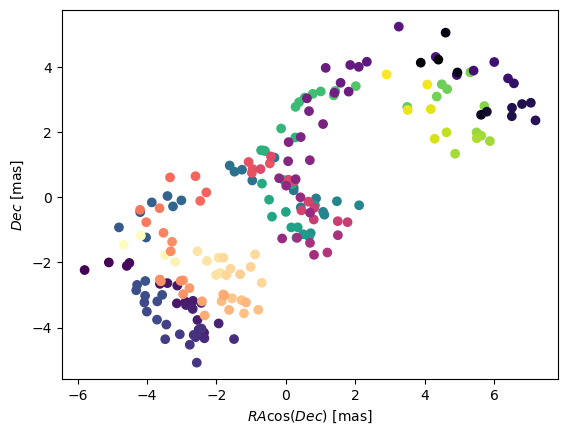

In [7]:
ast_error=0.3 # [mas]

obsracs=racs+ast_error*np.random.randn(ts.size)
obsdecs=decs+ast_error*np.random.randn(ts.size)

bobsracs=bracs+ast_error*np.random.randn(ts.size)
bobsdecs=bdecs+ast_error*np.random.randn(ts.size)

ax=plt.gca()
ax.scatter(obsracs,obsdecs,c=ts)
ax.scatter(bobsracs,bobsdecs,c=ts,cmap='magma_r')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyError.png')
plt.show()

In [8]:
results=astromet.simple_fit(ts,obsracs,obsdecs,ast_error,params.ra,params.dec)
print(results)

{'vis_periods': 71, 'n_obs': 100, 'drac': 0.004949897327668616, 'drac_error': 0.03176335083172477, 'ddec': -0.021213450860525795, 'ddec_error': 0.03176463460531146, 'drac_ddec_corr': 0.00019978275047102822, 'parallax': 1.9905719442203884, 'parallax_error': 0.035262500392067235, 'drac_parallax_corr': 0.012783600247429213, 'ddec_parallax_corr': 0.01562805051817892, 'pmrac': 3.929367236814857, 'pmrac_error': 0.04113401901080759, 'drac_pmrac_corr': 0.1992865256762524, 'ddec_pmrac_corr': 0.0030689678896392786, 'parallax_pmrac_corr': 0.19637560590614822, 'pmdec': 2.9794129698139242, 'pmdec_error': 0.040344635247613024, 'drac_pmdec_corr': 0.00030583141591801553, 'ddec_pmdec_corr': 0.20099203636101834, 'parallax_pmdec_corr': 0.023923731186722495, 'pmrac_pmdec_corr': 0.004698037207328443, 'uwe': 1.0371503545029197, 'ra_ref': 160, 'dec_ref': -50}


In [9]:
bresults=astromet.simple_fit(ts,bobsracs,bobsdecs,ast_error,params.ra,params.dec)
print(bresults)

{'vis_periods': 71, 'n_obs': 100, 'drac': 0.7495474316724807, 'drac_error': 0.05386152433991257, 'ddec': 0.6017844320668599, 'ddec_error': 0.05386370125136794, 'drac_ddec_corr': 0.0001997827504710282, 'parallax': 1.9938306287994614, 'parallax_error': 0.059795077453116845, 'drac_parallax_corr': 0.012783600247429212, 'ddec_parallax_corr': 0.015628050518178917, 'pmrac': 3.88925000448888, 'pmrac_error': 0.06975148742607439, 'drac_pmrac_corr': 0.1992865256762524, 'ddec_pmrac_corr': 0.003068967889639278, 'parallax_pmrac_corr': 0.1963756059061482, 'pmdec': 2.8931632186801397, 'pmdec_error': 0.06841291918117844, 'drac_pmdec_corr': 0.0003058314159180155, 'ddec_pmdec_corr': 0.2009920363610183, 'parallax_pmdec_corr': 0.023923731186722495, 'pmrac_pmdec_corr': 0.004698037207328443, 'uwe': 1.7587092545479586, 'ra_ref': 160, 'dec_ref': -50}


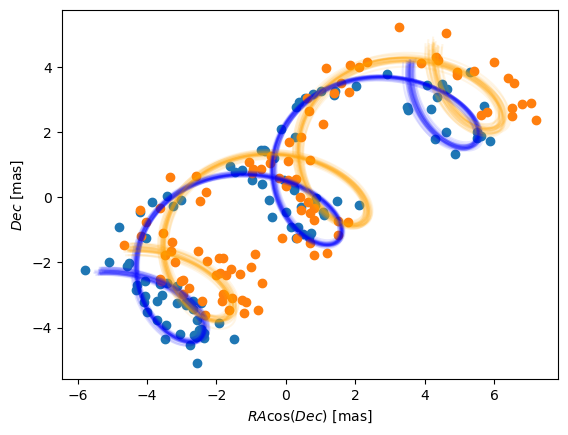

In [10]:
ax=plt.gca()
ax.scatter(obsracs,obsdecs)
ax.scatter(bobsracs,bobsdecs)

plotts=np.linspace(np.min(ts),np.max(ts),200)
fitparams=astromet.params()
bfitparams=astromet.params()
for i in range(32):
    fitparams.ra=160     #[deg]
    fitparams.dec=-50    #[deg]
    fitparams.drac=results['drac']+results['drac_error']*np.random.randn()     #[mas]
    fitparams.ddec=results['ddec']+results['ddec_error']*np.random.randn()     #[mas]
    fitparams.pmrac=results['pmrac']+results['pmrac_error']*np.random.randn()    #[mas/yr]
    fitparams.pmdec=results['pmdec']+results['pmdec_error']*np.random.randn()   #[mas/yr]
    fitparams.parallax=results['parallax']+results['parallax_error']*np.random.randn()     #[mas]
    
    fitracs,fitdecs=astromet.track(plotts,fitparams)
    ax.plot(fitracs,fitdecs,c='blue',alpha=0.1)
    
    bfitparams.ra=160     #[deg]
    bfitparams.dec=-50    #[deg]
    bfitparams.drac=bresults['drac']+bresults['drac_error']*np.random.randn()     #[mas]
    bfitparams.ddec=bresults['ddec']+bresults['ddec_error']*np.random.randn()     #[mas]
    bfitparams.pmrac=bresults['pmrac']+bresults['pmrac_error']*np.random.randn()    #[mas/yr]
    bfitparams.pmdec=bresults['pmdec']+bresults['pmdec_error']*np.random.randn()   #[mas/yr]
    bfitparams.parallax=bresults['parallax']+bresults['parallax_error']*np.random.randn()     #[mas]    

    bfitracs,bfitdecs=astromet.track(plotts,bfitparams)
    ax.plot(bfitracs,bfitdecs,c='orange',alpha=0.1)

ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyFit.png')
plt.show()

In [11]:
#import numpy as np
#import matplotlib.pyplot as plt
import scanninglaw.times

ra=160
dec=-50
c=scanninglaw.source.Source(ra,dec,unit='deg')

dr3_sl=scanninglaw.times.Times(version='dr3_nominal')
sl=dr3_sl(c, return_times=True, return_angles=True)

ts=np.squeeze(np.hstack(sl['times'])).astype('double')
sort=np.argsort(ts)
ts=2010+ts[sort]/365.25
phis=np.squeeze(np.hstack(sl['angles']))[sort].astype('double')

Loading auxilliary data ...
t = 43.771 s
  auxilliary:  18.138 s
          sf:   7.244 s
interpolator:  18.389 s


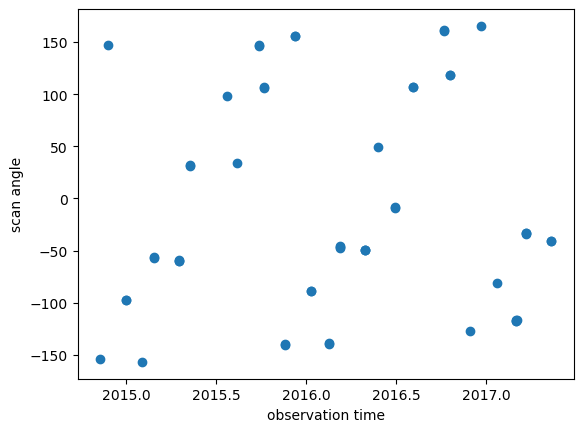

In [12]:
ax=plt.gca()
ax.scatter(ts,phis)
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'scan angle')
plt.savefig('docs/plots/scanningLaw.png')
plt.show()

In [13]:
params=astromet.params()

params.ra=ra
params.dec=dec
params.drac=0
params.ddec=0
params.pmrac=8
params.pmdec=-2
params.parallax=5

params.period=2
params.a=3 
params.e=0.5
params.q=0.5
params.l=0.1

params.vphi=4.5
params.vtheta=1.5
params.vomega=5.6

params.tperi=2016

racs,decs=astromet.track(ts,params)

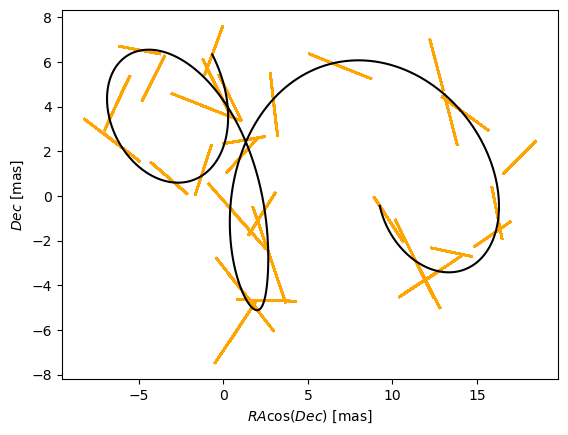

In [14]:
mag=18
al_error=astromet.sigma_ast(mag) # about 1.1 mas at this magnitude
errs=al_error*np.random.randn(phis.size)

radphis=np.deg2rad(phis)

obsracs=racs+errs*np.sin(radphis)
obsdecs=decs+errs*np.cos(radphis)

plotts=np.linspace(np.min(ts),np.max(ts),1000)
plotracs,plotdecs=astromet.track(plotts,params)

ax=plt.gca()
for i in range(ts.size):
    ax.plot([obsracs-al_error*np.sin(radphis),obsracs+al_error*np.sin(radphis)],
            [obsdecs-al_error*np.cos(radphis),obsdecs+al_error*np.cos(radphis)],c='orange')
ax.plot(plotracs,plotdecs,c='k')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyScans')
plt.show()

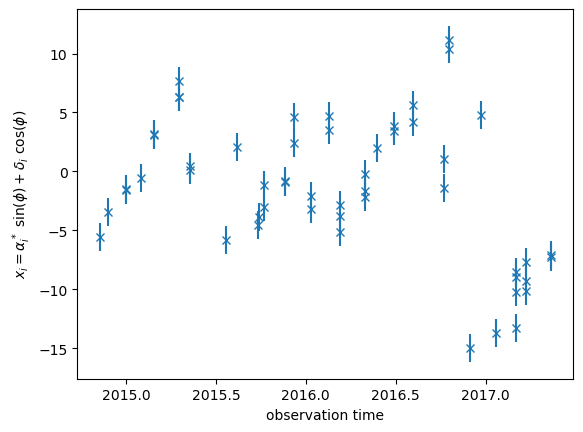

In [15]:
xs=obsracs*np.sin(radphis) + obsdecs*np.cos(radphis)

ax=plt.gca()
ax.errorbar(ts,xs,yerr=al_error,fmt='x')
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'$x_i = \alpha^*_i\ \sin(\phi) + \delta_i\ \cos(\phi)$')
plt.savefig('docs/plots/scanXs.png')
plt.show()

In [16]:
bresults=astromet.gaia_fit(ts,xs,phis,al_error,ra,dec)
print(bresults)

{'astrometric_matched_transits': 5, 'visibility_periods_used': 27, 'astrometric_n_obs_al': 53, 'astrometric_params_solved': 31, 'ra': 160.00000066639802, 'ra_error': 0.4516016025575448, 'dec': -49.999999500202236, 'dec_error': 0.4966806386130141, 'ra_dec_corr': 0.2069996460044999, 'parallax': 4.530128807770001, 'parallax_error': 0.6080567770022073, 'ra_parallax_corr': -0.07277591809454967, 'dec_parallax_corr': 0.048402344029454154, 'pmra': 8.515800052131953, 'pmra_error': 0.6020623801442265, 'ra_pmra_corr': -0.1806160906871172, 'dec_pmra_corr': 0.03814719197901632, 'parallax_pmra_corr': 0.2033507072442355, 'pmdec': -1.861193924423247, 'pmdec_error': 0.6481739377764314, 'ra_pmdec_corr': 0.0274092851180682, 'dec_pmdec_corr': -0.22509193520315174, 'parallax_pmdec_corr': 0.004164095476707267, 'pmra_pmdec_corr': 0.19241870137330913, 'astrometric_excess_noise': 1.9678033771486476, 'astrometric_chi2_al': 187.08110017767874, 'astrometric_n_good_obs_al': 53, 'uwe': 1.9742145071821113}
